In [2]:
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Extract historical financial data using YFinance for 

In [6]:

ticker=['TSLA','BND','SPY']
import datetime
div_data={}
yf_data=yf.download(ticker,start='2015-7-1',end='2025-7-31',actions=True,auto_adjust=True)
print(yf_data.head())

[*********************100%***********************]  3 of 3 completed

Price      Capital Gains           Close                        Dividends  \
Ticker               BND  SPY        BND         SPY       TSLA       BND   
Date                                                                        
2015-07-01           0.0  0.0  60.816750  174.917068  17.943333     0.163   
2015-07-02           0.0  0.0  60.967068  174.756973  18.667999     0.000   
2015-07-06           0.0  0.0  61.177578  174.259583  18.648001     0.000   
2015-07-07           0.0  0.0  61.237701  175.355438  17.858667     0.000   
2015-07-08           0.0  0.0  61.410641  172.413467  16.997334     0.000   

Price                      High              ...        Low       Open  \
Ticker      SPY TSLA        BND         SPY  ...       TSLA        BND   
Date                                         ...                         
2015-07-01  0.0  0.0  60.914475  175.363844  ...  17.856667  60.794198   
2015-07-02  0.0  0.0  61.027209  175.566234  ...  18.220667  60.936997   
2015-07-06  0

# Data cleaning and Understanding

In [26]:
import pandas as pd

# Normalize prices by first row
close_prices = yf_data['Close'] 
# Create DataFrames
closing_price_df = pd.DataFrame(
    close_prices,
    index=close_prices.index,
    columns=close_prices.columns
)




closing_price_df.to_csv('../data/scaled_closing_price.csv', index_label='Date')

print("Saved CSV in desired format.")


Saved CSV in desired format.


In [21]:
final

closing_price                      scaled_price                    
Ticker               BND       SPY       TSLA          BND       SPY      TSLA
Date                                                                          
2015-07-01      1.000000  1.000000   1.000000    -1.680487 -1.260073 -0.943161
2015-07-02      1.002472  0.999085   1.040386    -1.647477 -1.261339 -0.937166
2015-07-06      1.005933  0.996241   1.039272    -1.601249 -1.265274 -0.937332
2015-07-07      1.006922  1.002506   0.995282    -1.588045 -1.256605 -0.943861
2015-07-08      1.009765  0.985687   0.947279    -1.550068 -1.279879 -0.950986
...                  ...       ...        ...          ...       ...       ...
2025-07-24      1.195376  3.626976  17.014676     0.928842  2.375156  1.433828
2025-07-25      1.198326  3.642297  17.614342     0.968240  2.396358  1.522834
2025-07-28      1.196359  3.641383  18.145458     0.941974  2.395092  1.601665
2025-07-29      1.202586  3.631778  17.900800     1.025146  2.381801  1.565352
2025-07-30      1.199473  3.627205  17.780421     0.983562  2.375472  1.547484

[2535 rows x 6 columns]

# Conduct Exploratory Data Analysis (EDA):

##### Visualize the closing price over time to identify trends and patterns

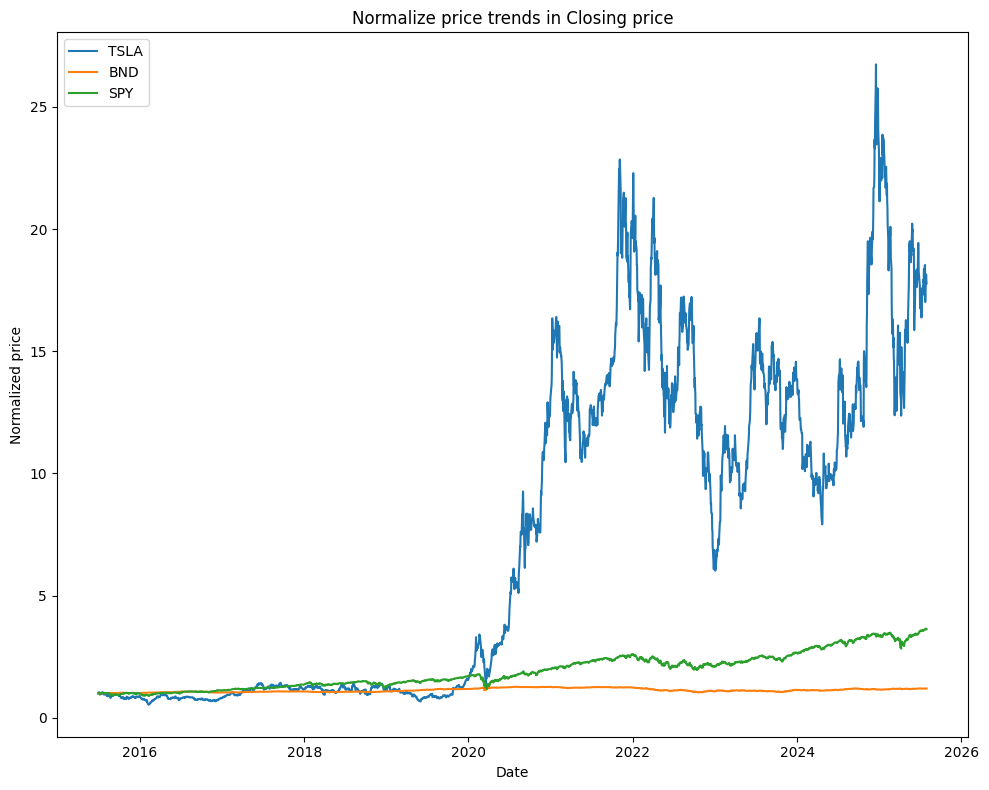

In [4]:
closing_price=yf_data['Close'].copy()
plt.figure(figsize=(10,8))
for stock in ticker:
    plt.plot(closing_price.index,closing_price[stock]/closing_price[stock].iloc[0],label=stock)
plt.title('Normalize price trends in Closing price')
plt.xlabel('Date')
plt.ylabel('Normalized price')
plt.legend()
plt.tight_layout()
plt.show()

##### Calculate and plot the daily percentage change to observe volatility

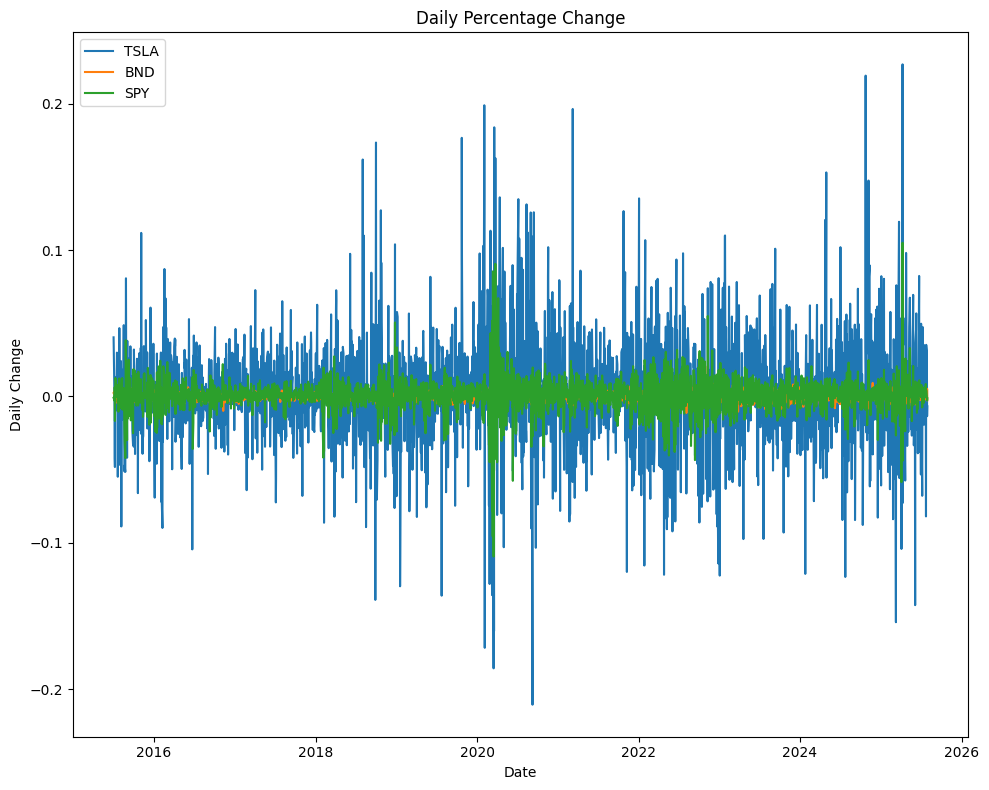

In [39]:
returns=closing_price.pct_change().dropna()

plt.figure(figsize=(10,8))
for stock in ticker:
    plt.plot(returns.index,returns[stock],label=stock)
plt.title("Daily Percentage Change")
plt.xlabel('Date')
plt.ylabel('Daily Change')
plt.legend()
plt.tight_layout()
plt.show()

##### Analyze volatility by calculating rolling means and standard deviations to understand short-term trends and fluctuations.

In [6]:
summary_stat=returns.describe().T
summary_stat['anualized_volatility'] =returns.std()* np.sqrt(252)
summary_stat['anualized_return']=returns.mean()*252
#return per risks
summary_stat['sharp_ratio']=summary_stat['anualized_return']/summary_stat['anualized_volatility']
print(summary_stat[['anualized_volatility' , 'anualized_return',  'sharp_ratio']].sort_values(by='sharp_ratio',ascending=False))



        anualized_volatility  anualized_return  sharp_ratio
Ticker                                                     
SPY                 0.182407          0.144844     0.794073
TSLA                0.591887          0.460690     0.778340
BND                 0.054919          0.019599     0.356879


##### Perform outlier detection to identify significantanomalies.Analyze days with unusually high or low returns

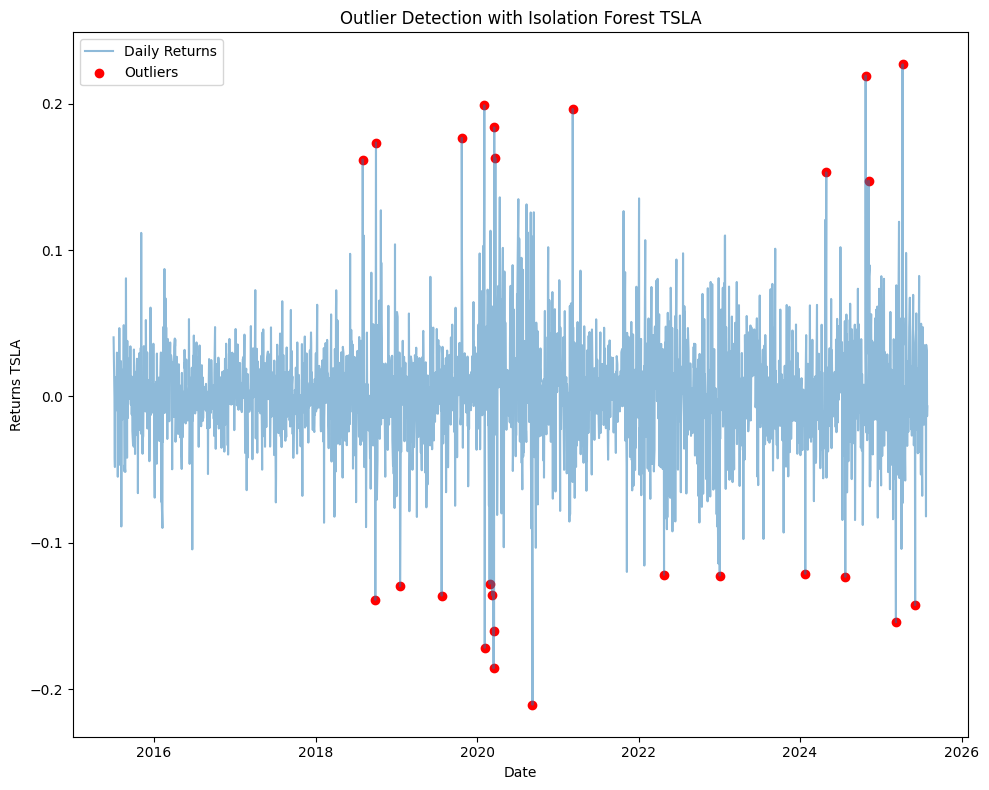

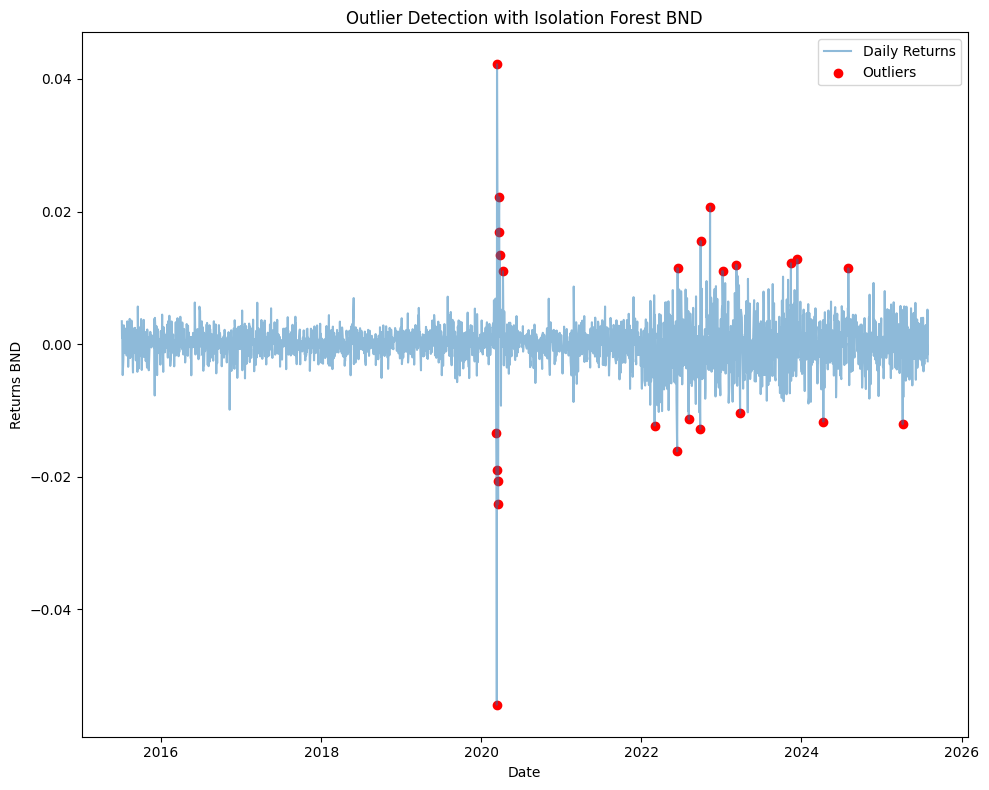

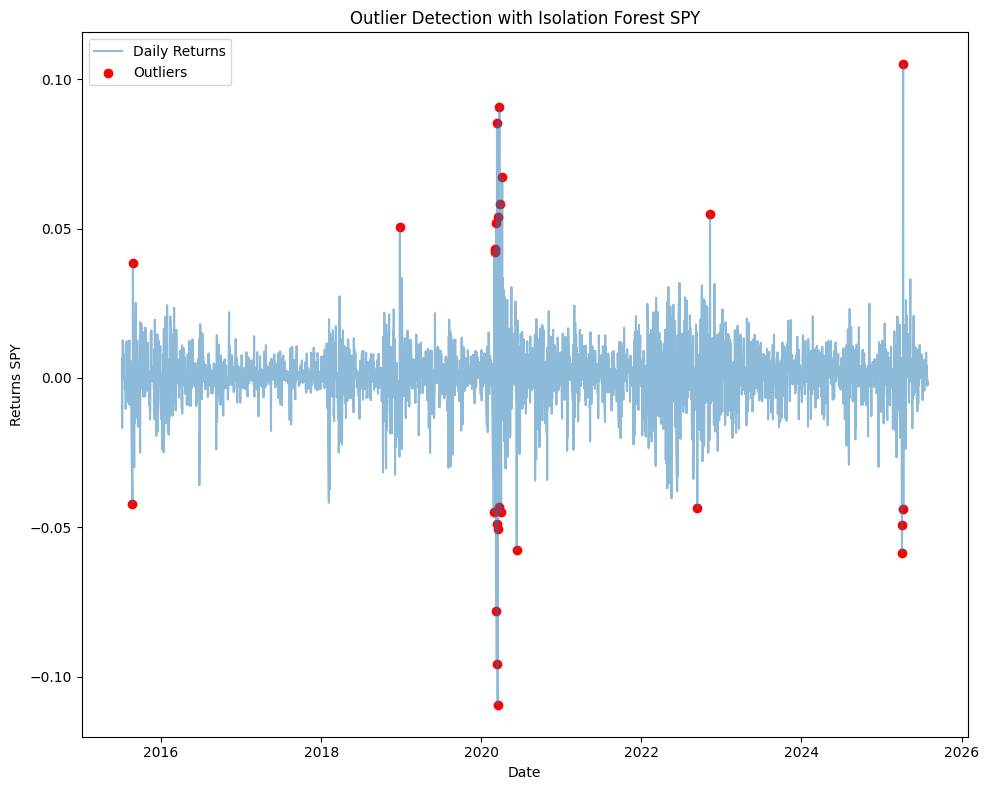

In [7]:
from sklearn.ensemble import IsolationForest
import matplotlib.pyplot as plt
for companey in ticker:

    returns = yf_data['Close'][companey].pct_change().dropna()
    yf_data = yf_data.loc[returns.index]
    yf_data['returns'] = returns
    iso_forest = IsolationForest(n_estimators=100, contamination=0.01, random_state=42)
    labels = iso_forest.fit_predict(returns.values.reshape(-1, 1))
    yf_data['outlier'] = labels
    normal = yf_data[yf_data['outlier'] == 1]
    outliers = yf_data[yf_data['outlier'] == -1]
    plt.figure(figsize=(10,8))
    plt.plot(yf_data.index, yf_data['returns'], label='Daily Returns', alpha=0.5)
    plt.scatter(outliers.index, outliers['returns'], color='red', label='Outliers')
    plt.xlabel('Date')
    plt.ylabel(f'Returns {companey}')
    plt.title(f'Outlier Detection with Isolation Forest {companey}')
    plt.legend()
    plt.tight_layout()
    plt.show()


# Seasonality and Trends

##### Perform a statistical test (e.g., Augmented Dickey-Fuller test) on the closing prices and daily returns.

In [8]:
from statsmodels.tsa.stattools import adfuller

def check_stationary(stock, data):
   
    data_clean = data.dropna()
    result = adfuller(data_clean)
    
    adf_stat = result[0]
    p_value = result[1]
    critical_values = result[4]
    
    print(f"\n=== Stationarity test for {stock} ===")
    print(f"ADF Statistic: {adf_stat:.4f}")
    print(f"P-value: {p_value:.4f}")
    print("Critical Values:")
    for level, cv in critical_values.items():
        print(f"  {level}: {cv:.4f}")
    
    
    if p_value < 0.05 and adf_stat < critical_values['5%']:
        print(f"Conclusion: {stock} is likely STATIONARY (rejects null hypothesis)")
    else:
        print(f"Conclusion: {stock} is likely NON-STATIONARY (fail to reject null hypothesis)")


for stock in ticker:
    print(f"\n--- Analyzing {stock} Closing Prices ---")
    check_stationary(stock, normal['Close'][stock])
    
    returns = normal['Close'][stock].pct_change()
    print(f"\n--- Analyzing {stock} Returns ---")
    check_stationary(stock, returns)



--- Analyzing TSLA Closing Prices ---

=== Stationarity test for TSLA ===
ADF Statistic: -1.4317
P-value: 0.5670
Critical Values:
  1%: -3.4330
  5%: -2.8627
  10%: -2.5674
Conclusion: TSLA is likely NON-STATIONARY (fail to reject null hypothesis)

--- Analyzing TSLA Returns ---

=== Stationarity test for TSLA ===
ADF Statistic: -11.6780
P-value: 0.0000
Critical Values:
  1%: -3.4330
  5%: -2.8627
  10%: -2.5674
Conclusion: TSLA is likely STATIONARY (rejects null hypothesis)

--- Analyzing BND Closing Prices ---

=== Stationarity test for BND ===
ADF Statistic: -1.5032
P-value: 0.5319
Critical Values:
  1%: -3.4330
  5%: -2.8627
  10%: -2.5674
Conclusion: BND is likely NON-STATIONARY (fail to reject null hypothesis)

--- Analyzing BND Returns ---

=== Stationarity test for BND ===
ADF Statistic: -23.2822
P-value: 0.0000
Critical Values:
  1%: -3.4330
  5%: -2.8627
  10%: -2.5674
Conclusion: BND is likely STATIONARY (rejects null hypothesis)

--- Analyzing SPY Closing Prices ---

=== S

In [19]:
yf_data

Price      Capital Gains           Close                         Dividends  \
Ticker               BND  SPY        BND         SPY        TSLA       BND   
Date                                                                         
2015-07-07           0.0  0.0  61.237732  175.355484   17.858667       0.0   
2015-07-08           0.0  0.0  61.410637  172.413498   16.997334       0.0   
2015-07-09           0.0  0.0  61.207684  172.725357   17.194668       0.0   
2015-07-10           0.0  0.0  60.921959  174.900238   17.276667       0.0   
2015-07-13           0.0  0.0  60.779121  176.830734   17.477333       0.0   
...                  ...  ...        ...         ...         ...       ...   
2025-07-24           0.0  0.0  72.698860  634.419983  305.299988       0.0   
2025-07-25           0.0  0.0  72.878265  637.099976  316.059998       0.0   
2025-07-28           0.0  0.0  72.758659  636.940002  325.589996       0.0   
2025-07-29           0.0  0.0  73.137398  635.260010  321.200012       0.0   
2025-07-30           0.0  0.0  72.948036  634.460022  319.040009       0.0   

Price                      High              ...        Open              \
Ticker      SPY TSLA        BND         SPY  ...         SPY        TSLA   
Date                                         ...                           
2015-07-07  0.0  0.0  61.470773  175.481925  ...  174.461933   18.333332   
2015-07-08  0.0  0.0  61.463259  174.293327  ...  174.006719   17.288000   
2015-07-09  0.0  0.0  61.327967  174.790654  ...  174.529321   17.271999   
2015-07-10  0.0  0.0  61.012171  175.321725  ...  174.740071   17.481333   
2015-07-13  0.0  0.0  60.899404  176.940312  ...  176.173215   17.483334   
...         ...  ...        ...         ...  ...         ...         ...   
2025-07-24  0.0  0.0  72.798528  636.150024  ...  634.599976  310.000000   
2025-07-25  0.0  0.0  72.878265  637.580017  ...  635.090027  308.739990   
2025-07-28  0.0  0.0  72.808497  638.039978  ...  637.479980  318.450012   
2025-07-29  0.0  0.0  73.147367  638.669983  ...  638.349976  325.549988   
2025-07-30  0.0  0.0  73.107503  637.679993  ...  635.919983  322.179993   

Price      Stock Splits             Volume                         returns  \
Ticker              BND  SPY TSLA      BND        SPY       TSLA             
Date                                                                         
2015-07-07          0.0  0.0  0.0  4183200  173820200   91576500  0.006289   
2015-07-08          0.0  0.0  0.0  1967800  164020100   93316500 -0.016777   
2015-07-09          0.0  0.0  0.0  1670900  144113100   50011500  0.001809   
2015-07-10          0.0  0.0  0.0  2038300  129456900   39163500  0.012592   
2015-07-13          0.0  0.0  0.0  2846500  106069400   44404500  0.011038   
...                 ...  ...  ...      ...        ...        ...       ...   
2025-07-24          0.0  0.0  0.0  6139200   71307100  156966000  0.000331   
2025-07-25          0.0  0.0  0.0  4845900   56865400  148227000  0.004224   
2025-07-28          0.0  0.0  0.0  5806600   54917100  112673800 -0.000251   
2025-07-29          0.0  0.0  0.0  7397900   60556300   87358900 -0.002638   
2025-07-30          0.0  0.0  0.0  5554600   80418900   83931900 -0.001259   

Price      outlier  
Ticker              
Date                
2015-07-07       1  
2015-07-08       1  
2015-07-09       1  
2015-07-10       1  
2015-07-13       1  
...            ...  
2025-07-24       1  
2025-07-25       1  
2025-07-28       1  
2025-07-29       1  
2025-07-30       1  

[2532 rows x 25 columns]

In [14]:
yf_data.to_csv('../data/time_serious.csv',index=True)

### closing price is not stationary because p > 0.05 and Augemented Dickey-fuller statistics is greater 5% values but the returns is stationary p < 0.05 and ADF statistics 5 % Critical point 

In [30]:
data = pd.read_csv('../data/time_serious.csv', header=[0, 1], parse_dates=[0], index_col=0)
